##Project 2: Data Representations and Clustering

Contributors:
1. Rachel Menezes (905508013)

2. bb

3. cc

###Part 1 - Clustering on Text Data

####Clustering with Sparse Text Representations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/Data-Representations-and-Clustering

/content/drive/MyDrive/Github/Data-Representations-and-Clustering


In [3]:
! git pull

Already up to date.


In [4]:
# "Import statements"
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import TruncatedSVD, NMF
from plotmat import plot_mat

In [5]:
random_state = 0
random.seed(random_state)
np.random.seed(random_state)

In [6]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_data = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers'), random_state=random_state)

In [7]:
print("Unique data target names: ",newsgroups_data.target_names)
print("Unique data targets: ",np.unique(newsgroups_data.target))

Unique data target names:  ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
Unique data targets:  [0 1 2 3 4 5 6 7]


In [8]:
# Functions needed
def convert_labels(train_dataset):
    """ Function to merge classes together and convert the problem into a binary classification problem """
    labels = []
    
    for label in train_dataset.target:
        name = train_dataset.target_names[label]
        if name.startswith('comp'):
            labels.append(0)
        elif name.startswith('rec'):
            labels.append(1)
        else:
            print('Wrong type: ', label)
    return labels

def print_clustering_measures(true_labels, pred_labels):
  homogeneity = homogeneity_score(true_labels, pred_labels)
  completeness = completeness_score(true_labels, pred_labels)
  v_measure = v_measure_score(true_labels, pred_labels)
  ari = adjusted_rand_score(true_labels, pred_labels)
  ami = adjusted_mutual_info_score(true_labels, pred_labels)

  # Print the 5 clustering measures
  print("\nClustering Measures:")
  print(f"* Homogeneity: {homogeneity:.3f}")
  print(f"* Completeness: {completeness:.3f}")
  print(f"* V-Measure: {v_measure:.3f}")
  print(f"* Adjusted Rand Index: {ari:.3f}")
  print(f"* Adjusted Mutual Information: {ami:.3f}")
  print()

In [9]:
vectorizer = TfidfVectorizer(min_df=3, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(newsgroups_data.data)

In [10]:
rows, columns = tfidf_matrix.shape
print(f"The TF-IDF matrix has {rows} rows (documents) and {columns} columns (features/words).")

The TF-IDF matrix has 4732 rows (documents) and 17131 columns (features/words).


In [11]:
true_labels = convert_labels(newsgroups_data)
print("Computer Technology maps to 0 and Recreational Activity to 1")

Computer Technology maps to 0 and Recreational Activity to 1


In [12]:
kmeans = KMeans(n_clusters=2, random_state=random_state, max_iter=1000, n_init=30)
kmeans.fit(tfidf_matrix)
pred_labels = kmeans.predict(tfidf_matrix)

In [13]:
contingency_table = contingency_matrix(true_labels, pred_labels)

Contingency Table:


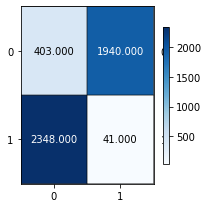

In [14]:
# Print the contingency table
print("Contingency Table:")
plot_mat(contingency_table, size=(3,3))

In [15]:
print_clustering_measures(true_labels, pred_labels)


Clustering Measures:
* Homogeneity: 0.590
* Completeness: 0.601
* V-Measure: 0.595
* Adjusted Rand Index: 0.660
* Adjusted Mutual Information: 0.595



#### Clustering with Dense Text Representations

In [16]:
# Apply Truncated SVD to the TF-IDF matrix
svd = TruncatedSVD(n_components=1000)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

In [17]:
# Compute the explained variance ratio for each component
explained_variance_ratio = svd.explained_variance_ratio_
ratio = svd.explained_variance_ratio_.cumsum()

Text(0, 0.5, 'Percentage of Variance')

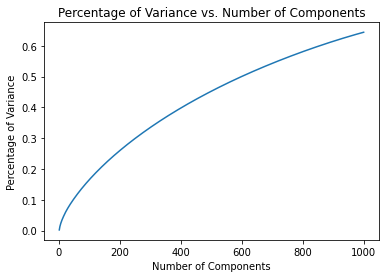

In [18]:
# Make a plot
plt.plot(range(1, 1001), ratio)
plt.title('Percentage of Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Variance')

In [19]:
# Perform SVD
ranks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
hs_svd, cs_svd, vs_svd, ars_svd, ams_svd = [], [], [], [], []

for r in ranks:
    # Apply SVD
    svd = TruncatedSVD(n_components=r)
    reduced_data = svd.fit_transform(tfidf_matrix)
    
    kmeans_svd = KMeans(n_clusters=2, random_state=random_state, max_iter=1000, n_init=30)
    y_pred = kmeans_svd.fit_predict(reduced_data)
    
    hs_svd.append(homogeneity_score(true_labels, y_pred))
    cs_svd.append(completeness_score(true_labels, y_pred))
    vs_svd.append(v_measure_score(true_labels, y_pred))
    ars_svd.append(adjusted_rand_score(true_labels, y_pred))
    ams_svd.append(adjusted_mutual_info_score(true_labels, y_pred))

In [20]:
def plot_dense_scores(ranks, hs, cs, vs, ars, ams, title):  
  plt.plot(ranks, hs, label = "Homogeneity")
  plt.plot(ranks, cs, label = "Completeness")
  plt.plot(ranks, vs, label = "V-measure")
  plt.plot(ranks, ars, label = "Adjusted Rand Index")
  plt.plot(ranks, ams, label = "Adjusted Mutual Information")
  plt.title(title)
  plt.xlabel("r (number of principal components)")
  plt.ylabel("Scores")
  plt.legend()

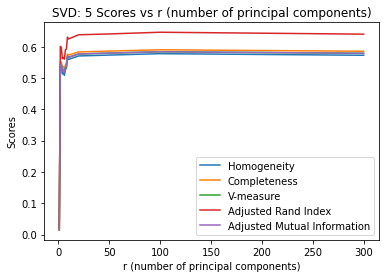

In [21]:
plot_dense_scores(ranks, hs_svd, cs_svd, vs_svd, ars_svd, ams_svd, "SVD: 5 Scores vs r (number of principal components)")

In [22]:
ranks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
hs_nmf, cs_nmf, vs_nmf, ars_nmf, ams_nmf = [], [], [], [], []
for r in ranks:
    # Apply NMF
    nmf = NMF(n_components=r)
    reduced_data = nmf.fit_transform(tfidf_matrix)
    kmeans_nmf = KMeans(n_clusters=2, random_state=random_state, max_iter=1000, n_init=30)
    y_pred = kmeans_nmf.fit_predict(reduced_data)
    
    hs_nmf.append(homogeneity_score(true_labels, y_pred))
    cs_nmf.append(completeness_score(true_labels, y_pred))
    vs_nmf.append(v_measure_score(true_labels, y_pred))
    ars_nmf.append(adjusted_rand_score(true_labels, y_pred))
    ams_nmf.append(adjusted_mutual_info_score(true_labels, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed fro

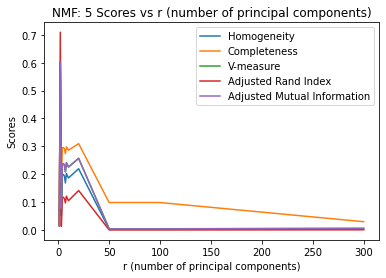

In [23]:
plot_dense_scores(ranks, hs_nmf, cs_nmf, vs_nmf, ars_nmf, ams_nmf, "NMF: 5 Scores vs r (number of principal components)")

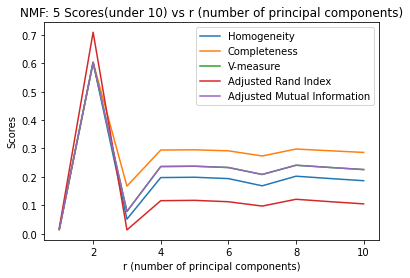

In [24]:
# Make a plot by keeping r within 10 to identify best r
plot_dense_scores(ranks[:10], hs_nmf[:10], cs_nmf[:10], vs_nmf[:10], ars_nmf[:10], ams_nmf[:10], "NMF: 5 Scores(under 10) vs r (number of principal components)")

###Part 2 - Visualize the clusters


Clustering Measures:
* Homogeneity: 0.583
* Completeness: 0.595
* V-Measure: 0.589
* Adjusted Rand Index: 0.653
* Adjusted Mutual Information: 0.589



Text(0.5, 1.0, 'Predicted cluster (SVD)')

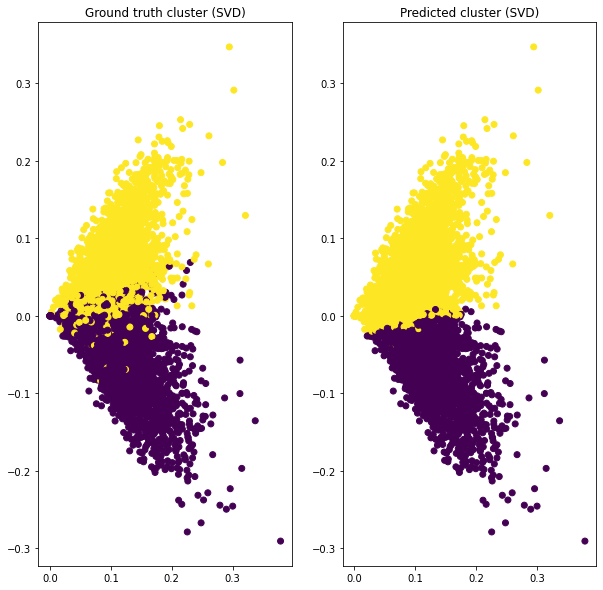

In [25]:
# SVD (300)
svd = TruncatedSVD(n_components=300)
data_svd_300 = svd.fit_transform(tfidf_matrix)

plt.figure(figsize=(10, 10))

kmeans_model = KMeans(n_clusters=2, random_state=random_state, max_iter=1000, n_init=30)
y_pred = kmeans_model.fit_predict(data_svd_300)

print_clustering_measures(true_labels, y_pred)

plt.subplot(121)
plt.scatter(data_svd_300[:, 0], data_svd_300[:, 1], c=true_labels)
plt.title("Ground truth cluster (SVD)")

plt.subplot(122)
plt.scatter(data_svd_300[:, 0], data_svd_300[:, 1], c=y_pred)
plt.title("Predicted cluster (SVD)")

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(



Clustering Measures:
* Homogeneity: 0.603
* Completeness: 0.604
* V-Measure: 0.603
* Adjusted Rand Index: 0.709
* Adjusted Mutual Information: 0.603



Text(0.5, 1.0, 'Predicted cluster (NMF)')

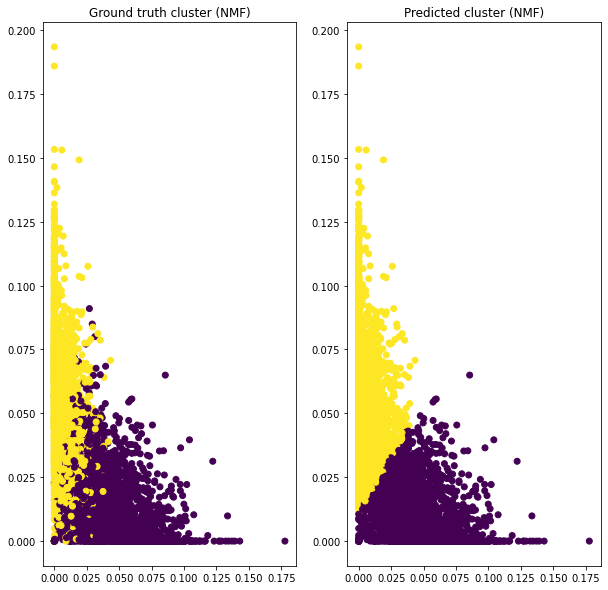

In [26]:
# NMF(2)
nmf = NMF(n_components=2)
data_nmf_2 = nmf.fit_transform(tfidf_matrix)
plt.figure(figsize=(10, 10))

# Train a k-means model
kmeans_model = KMeans(n_clusters=2, random_state=random_state, max_iter=1000, n_init=30)
y_pred = kmeans_model.fit_predict(data_nmf_2)

print_clustering_measures(true_labels, y_pred)

plt.subplot(121)
plt.scatter(data_nmf_2[:, 0], data_nmf_2[:, 1], c=true_labels)
plt.title("Ground truth cluster (NMF)")

plt.subplot(122)
plt.scatter(data_nmf_2[:, 0], data_nmf_2[:, 1], c=y_pred)
plt.title("Predicted cluster (NMF)")

In [28]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"
! git commit -am "updated subset to train from all"


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@132af1bb4255.(none)')
